# Imports Necessary Modules

In [ ]:
!pip install kaggle

In [ ]:
!kaggle datasets download paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100% 2.29G/2.29G [01:43<00:00, 24.4MB/s]
100% 2.29G/2.29G [01:43<00:00, 23.7MB/s]


In [ ]:
!unzip chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

import os
source_folder = '/content/chest_xray'
destination_folder = '/content/drive/MyDrive/chest'

!cp -r "{source_folder}" "{destination_folder}"

if os.path.exists(destination_folder):
    print(f"Dataset successfully saved to {destination_folder}")
else:
    print("Failed to save the dataset to Google Drive.")

In [7]:
import os
import cv2
import numpy as np
import tensorflow as tf
from random import sample
from os import mkdir, listdir
from collections import Counter
import matplotlib.pyplot as plt
from shutil import copyfile, rmtree
from tensorflow.keras import layers, models, optimizers
import warnings
warnings.filterwarnings("ignore")

In [2]:
base_dir = '/content/drive/MyDrive/chest'

train_dir = f'{base_dir}/train'
valid_dir = f'{base_dir}/val'
test_dir = f'{base_dir}/test'

## Counting Images in the Training Set

In [ ]:
print("Train set:\n========================================")
print(f"PNEUMONIA={len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))} images")
print(f"NORMAL={len(os.listdir(os.path.join(train_dir, 'NORMAL')))} images")

Train set:
PNEUMONIA=1075 images
NORMAL=1041 images


## Counting Images in the Test Set

In [ ]:
print("Test set:\n========================================")
print(f"PNEUMONIA={len(os.listdir(os.path.join(test_dir, 'PNEUMONIA')))} images")
print(f"NORMAL={len(os.listdir(os.path.join(test_dir, 'NORMAL')))} images")

Test set:
PNEUMONIA=390 images
NORMAL=384 images


## Counting Images in the Validation Set

In [ ]:
print("Validation set:\n========================================")
print(f"PNEUMONIA={len(os.listdir(os.path.join(valid_dir, 'PNEUMONIA')))} images")
print(f"NORMAL={len(os.listdir(os.path.join(valid_dir, 'NORMAL')))} images")

Validation set:
PNEUMONIA=308 images
NORMAL=308 images


## Visualizing Image Counts Across Classes for Train, Validation, and Test Sets

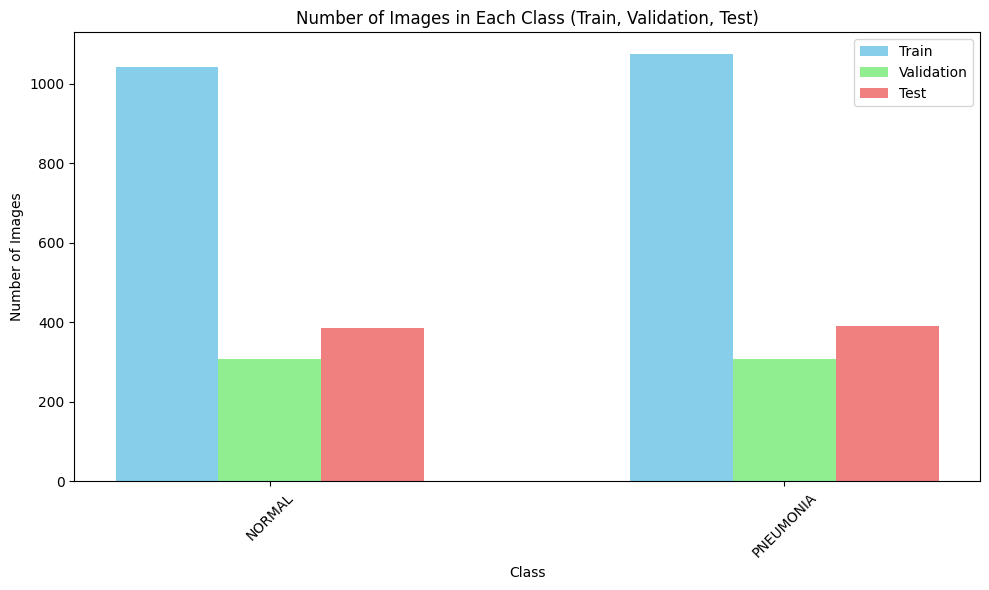

In [3]:
def count_images_in_classes(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            num_images = len(os.listdir(class_path))
            class_counts[class_name] = num_images
    return class_counts

train_counts = count_images_in_classes(train_dir)
valid_counts = count_images_in_classes(valid_dir)
test_counts = count_images_in_classes(test_dir)
all_classes = list(train_counts.keys())
train_values = [train_counts.get(cls, 0) for cls in all_classes]
valid_values = [valid_counts.get(cls, 0) for cls in all_classes]
test_values = [test_counts.get(cls, 0) for cls in all_classes]
x = np.arange(len(all_classes))
width = 0.2

plt.figure(figsize=(10, 6))
plt.bar(x - width, train_values, width, label='Train', color='skyblue')
plt.bar(x, valid_values, width, label='Validation', color='lightgreen')
plt.bar(x + width, test_values, width, label='Test', color='lightcoral')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Class (Train, Validation, Test)')
plt.xticks(x, all_classes, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

## Preprocessing for Images Resizing and Normalization and convert to RGB

In [4]:
target_size = (224, 224)

def preprocess_grayscale_to_rgb(image):
    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    image = cv2.resize(image, target_size)
    image = image.astype(np.float32) / 255.0
    return image

## Function Load and Preprocess Images

In [5]:
def load_and_preprocess_images(directory_path):
    images = []
    labels = []
    class_names = sorted(os.listdir(directory_path))
    for label, class_name in enumerate(class_names):
        class_folder_path = os.path.join(directory_path, class_name)
        if os.path.isdir(class_folder_path):
            for image_name in os.listdir(class_folder_path):
                image_path = os.path.join(class_folder_path, image_name)
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                image = preprocess_grayscale_to_rgb(image)
                images.append(image)
                labels.append(label)
    return np.array(images), np.array(labels), class_names

## Load and Preprocess Images

In [8]:
train_images, train_labels,class_names = load_and_preprocess_images(train_dir)
val_images, val_labels,class_names = load_and_preprocess_images(valid_dir)
test_images, test_labels,class_names = load_and_preprocess_images(test_dir)
print(f"Training data shape: {train_images.shape}")
print(f"Validation data shape: {val_images.shape}")
print(f"Test data shape: {test_images.shape}")


Training data shape: (2116, 224, 224, 3)
Validation data shape: (616, 224, 224, 3)
Test data shape: (774, 224, 224, 3)


## Some Info About the Data

In [9]:
print(f"Number of training images: {len(train_images)}")
print(f"Shape of training images: {train_images.shape}")
print(f"Number of validation images: {len(val_images)}")
print(f"Shape of validation images: {val_images.shape}")
print(f"Shape of test images: {test_images.shape}")
print(f"Number of test images: {len(test_images)}")

Number of training images: 2116
Shape of training images: (2116, 224, 224, 3)
Number of validation images: 616
Shape of validation images: (616, 224, 224, 3)
Shape of test images: (774, 224, 224, 3)
Number of test images: 774


## Shuffle the Training Set

In [11]:
indices = np.random.permutation(len(train_images))
train_images = train_images[indices]
train_labels = train_labels[indices]
print(f"Sample training labels: {train_labels[:10]}")

Sample training labels: [1 0 0 1 0 1 1 0 1 0]


## Visualizing a Batch of Images with Their Labels from the Training Set

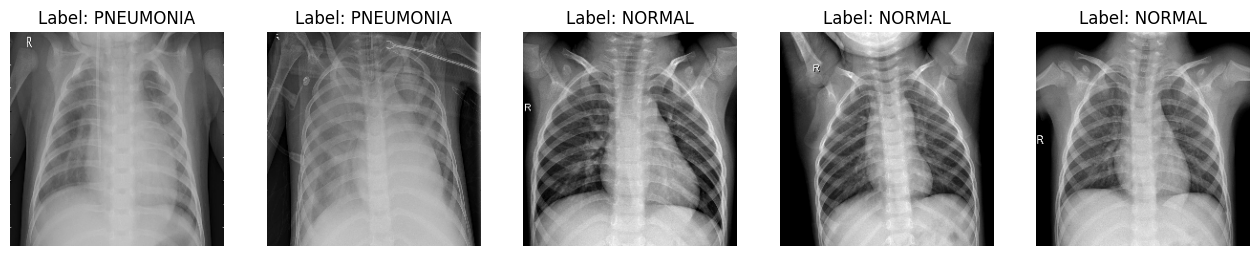

In [ ]:
def display_images(images, labels, class_names, num_images=5):
    plt.figure(figsize=(16, 10))
    random_indices = np.random.choice(len(images), num_images, replace=False)

    for i, idx in enumerate(random_indices):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[idx])
        plt.title(f"Label: {class_names[labels[idx]]}")
        plt.axis('off')
    plt.show()
class_names = ["NORMAL", "PNEUMONIA"]
display_images(train_images, train_labels,class_names, num_images=5)


# DenseNet121 Model

In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers, models
import tensorflow as tf

base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers[:36]:
    layer.trainable = False

for layer in base_model.layers[36:]:
    layer.trainable = True

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


# Train the Model

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images, train_labels,
    epochs=10,
    batch_size=16,
    validation_data=(val_images, val_labels),
    callbacks=[tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', patience=3, restore_best_weights=True
    )]
)

Epoch 1/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 339s 1s/step - accuracy: 0.6958 - loss: 0.5753 - val_accuracy: 0.9334 - val_loss: 0.2669
Epoch 2/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 60s 143ms/step - accuracy: 0.9269 - loss: 0.2191 - val_accuracy: 0.9367 - val_loss: 0.1818
Epoch 3/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 21s 147ms/step - accuracy: 0.9482 - loss: 0.1505 - val_accuracy: 0.9416 - val_loss: 0.1722
Epoch 4/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 20s 146ms/step - accuracy: 0.9641 - loss: 0.1220 - val_accuracy: 0.9497 - val_loss: 0.1528
Epoch 5/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 21s 153ms/step - accuracy: 0.9758 - loss: 0.0788 - val_accuracy: 0.9627 - val_loss: 0.1160
Epoch 6/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 19s 144ms/step - accuracy: 0.9789 - loss: 0.0715 - val_accuracy: 0.9740 - val_loss: 0.0835
Epoch 7/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 20s 147ms/step - accuracy: 0.9877 - loss: 0.0441 - val_accuracy: 0.9756 - val_loss: 0.0699
Epoch 8/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 19s 145ms/step - accuracy: 0.9912 - loss: 0.0

# Model Summary

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)             │ (None, 7, 7, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,299,909 (81.25 MB)

 Trainable params: 6,999,873 (26.70 MB)

 Non-trainable params: 300,288 (1.15 MB)

 Optimizer params: 13,999,748 (53.40 MB)

#  Evaluating the Model Performance

In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Test accuracy: {test_acc * 100:.2f}%")

25/25 ━━━━━━━━━━━━━━━━━━━━ 22s 456ms/step - accuracy: 0.8800 - loss: 0.3659
Test accuracy: 95.74%


## Training and Validation Accuracy

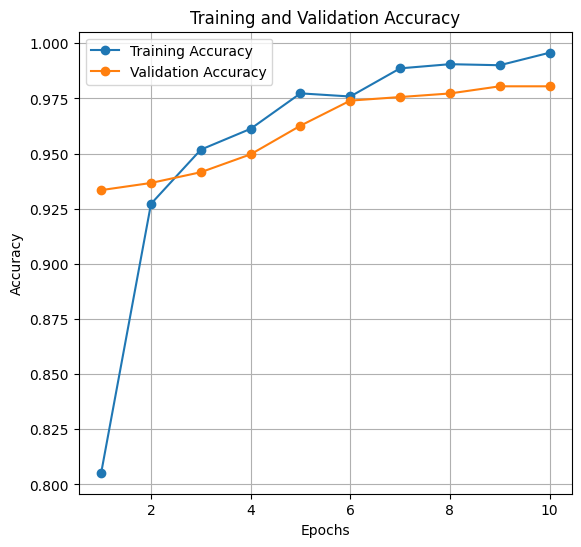

In [ ]:
import matplotlib.pyplot as plt

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(train_acc) + 1)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, label='Training Accuracy', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.show()

## Training and Validation Loss

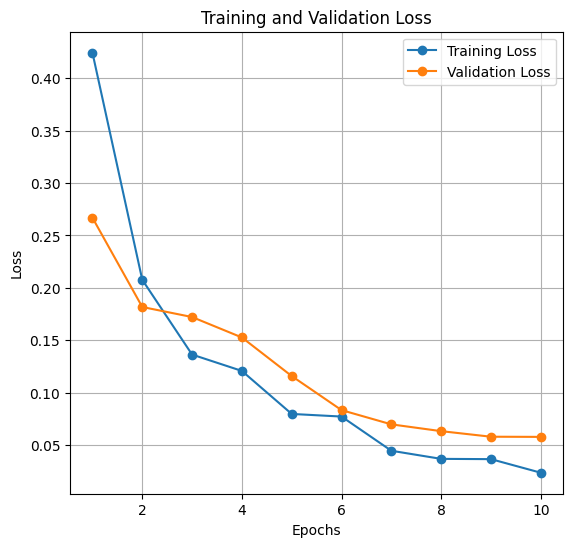

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)

plt.plot(epochs, train_loss, label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

# Confusion Matrix

25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 454ms/step


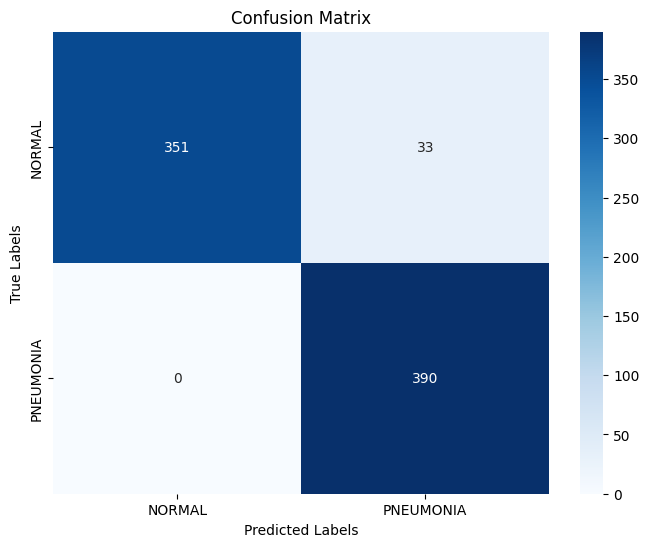

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_pred_probs = model.predict(test_images)
y_pred = (y_pred_probs > 0.5).astype(int)

cm = confusion_matrix(test_labels, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()


# Classification Report

In [ ]:
print("Classification Report:")
print(classification_report(test_labels, y_pred, target_names=class_names))

Classification Report:
              precision    recall  f1-score   support

      NORMAL       1.00      0.91      0.96       384
   PNEUMONIA       0.92      1.00      0.96       390

    accuracy                           0.96       774
   macro avg       0.96      0.96      0.96       774
weighted avg       0.96      0.96      0.96       774



## ROC curve and AUC

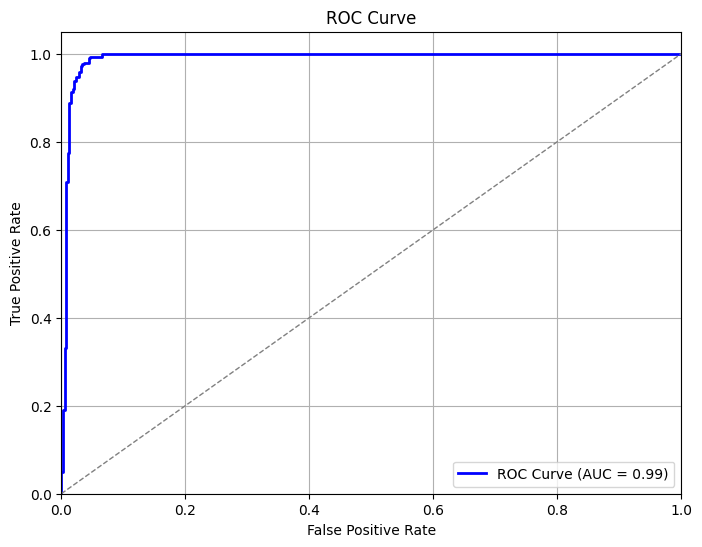

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(test_labels, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')  
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()


# Saving the Model

In [ ]:
model.save('DenseNet121.h5')

# Load Trained Model and Predict Class from a New Image

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
Predicted: NORMAL


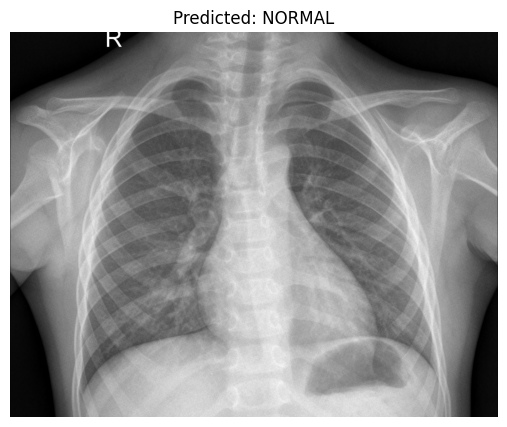

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('DenseNet121.h5')
target_size = (224, 224)

def load_and_preprocess_image(image_path, target_size):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError(f"Failed to load image from {image_path}")
    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    image = cv2.resize(image, target_size)
    image = image.astype(np.float32) / 255.0
    return image

image_path = '/content/drive/MyDrive/chest/test/NORMAL/IM-0010-0001.jpeg'
image_for_prediction = load_and_preprocess_image(image_path, target_size)

image_for_prediction = np.expand_dims(image_for_prediction, axis=0)
prediction = model.predict(image_for_prediction)
predicted_class = np.argmax(prediction, axis=1)[0]
class_labels = ['NORMAL', 'PNEUMONIA']

print(f"Predicted: {class_labels[predicted_class]}")
plt.figure(figsize=(10, 5))
plt.imshow(cv2.imread(image_path, cv2.IMREAD_GRAYSCALE), cmap='gray')
plt.title(f"Predicted: {class_labels[predicted_class]}")
plt.axis('off')
plt.show()
